# Autolabelling Pipeline

Want to:
- Create a set of functions for autolabelling
    - E.g. pass a folder of raw images and create a labels file for them
- Make a set of zero-shot classification functions with CLIP/BLIP to label images with several parameters:
    - "edible_food" vs "other"
    - "contains_logo" vs "no_logo"
    - "contains_text" vs "no_text"
    - "contains_human" vs "no_human"
    - "apple", "banana"... etc (for different food classes)
- Want to do this to create a very large dataset of *only* food images 

In [29]:
# Append the upper level directory to sys
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

from pathlib import Path

In [30]:
# Get list of all paths in food_photos directory
path = Path('food_photos')
all_paths = list(path.glob('*/*.jpeg'))
all_paths[:10]

[PosixPath('food_photos/watermelon/913bb78d-c704-4dfe-9f18-e8223f4fe888.jpeg'),
 PosixPath('food_photos/watermelon/25660bf7-b26f-4976-9905-fb73249506cb.jpeg'),
 PosixPath('food_photos/watermelon/3a220ede-65a6-4fcd-aed4-f956c7c3bce9.jpeg'),
 PosixPath('food_photos/watermelon/7d86f328-ffcd-46b0-8bbe-8dd3bc11fc03.jpeg'),
 PosixPath('food_photos/watermelon/3205f1ea-6c4f-41cb-ae2c-5c1c8dfaec53.jpeg'),
 PosixPath('food_photos/watermelon/3771b888-1079-451a-a745-6d2ae8000ff3.jpeg'),
 PosixPath('food_photos/coleslaw/06996f78-557a-4dac-a744-fd31e24d2f85.jpeg'),
 PosixPath('food_photos/coleslaw/60815bb4-f920-4f4d-8648-02ba3e9c0e95.jpeg'),
 PosixPath('food_photos/coleslaw/d9ec8c9c-0510-4406-9cfe-b958db425e04.jpeg'),
 PosixPath('food_photos/coleslaw/0a908773-f8f3-4143-88f8-5bc4d4f01a96.jpeg')]

In [31]:
# Next:
# Create functions for zero-shot classifiers
# Go through all the paths apply the zero-shot classifiers
# Add some images which are examples which should be food/not food etc
# The model should pick these up...
# Create labels for the images based on the results of the zero-shot classifiers

In [32]:
import torch
from lavis.models import load_model_and_preprocess
from PIL import Image

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO: move to utils.py?
def open_image(image_path_or_PIL):
    try:
        return Image.open(image_path_or_PIL).convert("RGB")
    except:
        return image_path_or_PIL.convert("RGB")

misc_dict = {"chicken": 123,
             "pizza": 456,
             "hot dog": 789}

# TODO: move to utils.py
# Create a function to sort dict by values
def sort_dict_by_values(dict_to_sort):
    sorted_dict = dict(sorted(dict_to_sort.items(), key=lambda x:x[1], reverse=True))
    return sorted_dict
    # return {k: v for k, v in sorted(dict_to_sort.items(), key=lambda item: item[1], reverse=True)}

sort_dict_by_values(misc_dict)

#### BLIP ####

# Start Vision-Language modelling section
blip_feature_extractor_model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_feature_extractor", 
                                                                                         model_type="base", 
                                                                                         is_eval=True, 
                                                                                         device=device)

def blip_get_image_features(image,
                            model=blip_feature_extractor_model, 
                            vis_processors=vis_processors, 
                            device=device,
                            low_dim=True):

    # Make sure model and image are on the same device
    blip_feature_extractor_model.to(device)
                 
    # Preprocess image
    image = vis_processors["eval"](image).unsqueeze(0).to(device)

    # Turn image into sample dict
    sample = {"image": image}

    # Get features
    features_image = model.extract_features(sample, mode="image")

    # Turn features into low-dim
    if low_dim:
        features_image = features_image.image_embeds_proj
    else:
        features_image = features_image.image_embeds

    return features_image

def blip_get_text_features(text: list,
                           model=blip_feature_extractor_model, 
                           txt_processors=txt_processors, 
                           device=device,
                           low_dim=True):
                 
    # Preprocess image
    text_input = [txt_processors["eval"](text) for text in text]

    # Turn image into sample dict
    sample = {"text_input": text_input}

    # Get features
    features_text = model.extract_features(sample, mode="text")

    # Turn features into low-dim
    if low_dim:
        features_text = features_text.text_embeds_proj[:, 0]
    else:
        features_text = features_text.text_embeds[:, 0]

    return features_text.to(device)


### CLIP

### Load CLIP model and create helper functions
clip_feature_extractor_model, clip_vis_processors, clip_txt_processors = load_model_and_preprocess(name="clip_feature_extractor", 
                                                                                                   model_type="ViT-B-16", 
                                                                                                   is_eval=True, 
                                                                                                   device=device)

# Create a function to get CLIP image features
def clip_get_image_features(image, 
                            clip_feature_extractor_model=clip_feature_extractor_model, 
                            clip_vis_processors=clip_vis_processors, 
                            device=device):
    processed_image = clip_vis_processors["eval"](image).unsqueeze(0).to(device)
    sample = {"image": processed_image}
    clip_image_features = clip_feature_extractor_model.extract_features(sample)
    # clip_image_features = clip_features.image_embeds_proj
    return clip_image_features

def clip_get_text_features(text,  clip_feature_extractor_model=clip_feature_extractor_model, clip_txt_processors=clip_txt_processors, device=device):
    text_input = clip_txt_processors["eval"](text)
    sample = {"text_input": [text_input]}
    features_text = clip_feature_extractor_model.extract_features(sample)
    return features_text

# Create a function to get CLIP image features
def clip_get_image_features(image, 
                            clip_feature_extractor_model=clip_feature_extractor_model, 
                            clip_vis_processors=clip_vis_processors, 
                            device=device):
    processed_image = clip_vis_processors["eval"](image).unsqueeze(0).to(device)
    sample = {"image": processed_image}
    clip_image_features = clip_feature_extractor_model.extract_features(sample)
    # clip_image_features = clip_features.image_embeds_proj
    return clip_image_features

def clip_get_text_features(text:list,
                           model=clip_feature_extractor_model,
                           clip_txt_processors=clip_txt_processors,
                           device=device):
    text_input = [clip_txt_processors["eval"](text) for text in text]
    features = model.extract_features({"text_input": text_input})
    return features.to(device)



In [33]:
def blip_zero_shot_classification(image_features, text_features, class_names, blip_model=blip_feature_extractor_model, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    similarity_values = (image_features @ text_features.t())[0] / blip_model.temp
    probabilities = torch.softmax(similarity_values, dim=0).cpu().tolist()

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict


def clip_zero_shot_classification(image_features, text_features, class_names, clip_model=clip_feature_extractor_model, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    similarity_values = (image_features @ text_features.T)[0] / 0.01
    probabilities = torch.softmax(similarity_values, dim=0).cpu().tolist() # return values to CPU

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict

### OpenCLIP helper functions

In [34]:
import torch
from PIL import Image
import open_clip
from tqdm.auto import tqdm

open_clip_model_name = "ViT-H-14"
open_clip_model, _, open_clip_preprocess = open_clip.create_model_and_transforms(open_clip_model_name, pretrained='laion2b_s32b_b79k')
open_clip_tokenizer = open_clip.get_tokenizer(open_clip_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
open_clip_model.to(device);

def open_clip_compute_image_features_of_list(image_paths: list,
                                             open_clip_model=open_clip_model,
                                             open_clip_preprocess=open_clip_preprocess,
                                             device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing OpenCLIP image features"):
        image_feature_dict = {}

        image = open_clip_preprocess(Image.open(image_path)).unsqueeze(0)

        with torch.no_grad(), torch.cuda.amp.autocast():
            open_clip_model.to(device)
            image_features = open_clip_model.encode_image(image.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)       

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features
        image_features_list.append(image_feature_dict)
    
    return image_features_list

def open_clip_get_text_features(text: list,
                                    open_clip_model=open_clip_model,
                                    open_clip_tokenizer=open_clip_tokenizer,
                                    device=device):

    text = open_clip_tokenizer(text)
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        open_clip_model.to(device)
        text_features = open_clip_model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    return text_features

def open_clip_zero_shot_classification(image_features, text_features, class_names, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    with torch.no_grad(), torch.cuda.amp.autocast():
        similarity_values = (image_features @ text_features.T)[0] / 0.01
        probabilities = torch.softmax(similarity_values, dim=-1).cpu().tolist() # return values to CPU

        # Create a dict of class names and their probabilities
        class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict

## Create lists of binary classifiers for sorting images

In [35]:
food_not_food = ["edible_food", "other"]
logo_not_logo = ["contains_logo", "other"]

In [36]:
# Create BLIP and CLIP features for binary classifiers
blip_food_not_food_features = blip_get_text_features(text=food_not_food, device="cpu")
clip_food_not_food_features = clip_get_text_features(text=food_not_food, device="cpu")
open_clip_food_not_food_features = open_clip_get_text_features(text=food_not_food, device="cpu")

# blip_logo_not_logo_features = blip_get_text_features_of_list(target_list=logo_not_logo, device="cpu")
# clip_logo_not_logo_features = clip_get_text_features_of_list(target_list=logo_not_logo, device="cpu")

In [37]:
blip_food_not_food_features.shape, clip_food_not_food_features.shape, open_clip_food_not_food_features.shape 

(torch.Size([2, 256]), torch.Size([2, 512]), torch.Size([2, 1024]))

In [38]:
blip_get_text_features(text=["pizza", "hot dog", "chicken"], device="cpu").shape

torch.Size([3, 256])

Now let's open each of the images and compute their zero-shot classification details.

In [39]:
def clip_compute_image_features_of_list(image_paths: list,
                                        device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing CLIP image features"):
        image_feature_dict = {}
        image = open_image(image_path)
        image_features = clip_get_image_features(image=image, device=device).to("cpu")

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features
        image_features_list.append(image_feature_dict)
    
    return image_features_list

def blip_compute_image_features_of_list(image_paths: list,
                                        device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing BLIP image features"):
        image_feature_dict = {}
        image = open_image(image_path)
        image_features = blip_get_image_features(image=image, device=device)

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features.cpu() # store image features on CPU to prevent extra memory usage
        image_features_list.append(image_feature_dict)
    
    return image_features_list

### Precompute image features for use later 

Computing image features takes the longest time so compute these first and save them for later.

In [40]:
blip_image_features_list = blip_compute_image_features_of_list(image_paths=all_paths, device="cuda")
# clip_image_features_list = clip_compute_image_features_of_list(image_paths=all_paths, device="cuda") # this results in out of memory errors (the GELU function in OpenAI clip is busted)
open_clip_image_features_list = open_clip_compute_image_features_of_list(image_paths=all_paths, device="cuda")

Computing BLIP image features:   0%|          | 0/1257 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1257 [00:00<?, ?it/s]

In [41]:
blip_image_features_list[0]["image_features"].shape
blip_image_features_list[0]["image_features"][:, 0].shape

torch.Size([1, 256])

In [42]:
from typing import List

def get_image_and_text_similarity_dicts(image_paths: list,
                                        target_classes: List[str],):
    
    # Set CLIP and BLIP to use GPU for creating image features if available
    img_feature_device = "cuda" if torch.cuda.is_available() else "cpu"

    # Encode text features on CPU (this is quick even for 100s of classes)
    blip_text_features = blip_get_text_features(text=target_classes, device="cpu") # only get dims for zero-shot classification
    open_clip_text_features = open_clip_get_text_features(text=target_classes, device="cpu")
    
    # Loop through image paths
    auto_created_labels = []
    for image_path in tqdm(image_paths, desc="Calculating image features and similarity dicts"):

        # Match image path to pre-computed image features
        # print(image_paths.index(image_path))
        open_clip_img_features = open_clip_image_features_list[image_paths.index(image_path)]["image_features"]
        blip_img_features = blip_image_features_list[image_paths.index(image_path)]["image_features"][:, 0] # TODO: could the indexing be cleaner?
        
        # Get sorted similarity dicts
        open_clip_similarity_dict = open_clip_zero_shot_classification(open_clip_img_features, open_clip_text_features, target_classes, sorted=True)
        blip_similarity_dict = blip_zero_shot_classification(blip_img_features, blip_text_features, target_classes, sorted=True)

        # Average the values of the similarity dicts
        avg_similarity_dict = {}
        for key in open_clip_similarity_dict.keys():
            avg_similarity_dict[key] = (open_clip_similarity_dict[key] + blip_similarity_dict[key]) / 2
        
        # Sort the average similarity dict and reduce length to 5
        avg_similairty_dict = dict(list(sort_dict_by_values(avg_similarity_dict).items())[:5])

        # If the length of the similarity dicts is over 5, shorten to only get top 5
        if len(open_clip_similarity_dict) > 5:
            open_clip_similarity_dict = dict(list(open_clip_similarity_dict.items())[:5])
        
        if len(blip_similarity_dict) > 5:
            blip_similarity_dict = dict(list(blip_similarity_dict.items())[:5])
        
        # Append to list
        auto_created_labels.append({"image_path": image_path,
                                    "blip_sorted_similarity_dict": blip_similarity_dict,
                                    "blip_top_1_class_name": list(blip_similarity_dict.keys())[0],
                                    "blip_top_1_similarity_score": list(blip_similarity_dict.values())[0],
                                    "open_clip_sorted_similarity_dict": open_clip_similarity_dict,
                                    "open_clip_top_1_class_name": list(open_clip_similarity_dict.keys())[0],
                                    "open_clip_top_1_similarity_score": list(open_clip_similarity_dict.values())[0],
                                    "avg_sorted_similarity_dict": avg_similarity_dict,
                                    "avg_top_1_class_name": list(avg_similarity_dict.keys())[0],
                                    "avg_top_1_similarity_score": list(avg_similarity_dict.values())[0]})
    
    return auto_created_labels

In [45]:
# target_classes = ["logo", "no_logo"]

food_labels = sorted(list(set([p.parent.name for p in all_paths])))
food_labels.append("other")

print(food_labels)
       
target_classes = food_labels
zero_shot_labels = get_image_and_text_similarity_dicts(image_paths=all_paths,
                                                       target_classes=target_classes)

['apple_green', 'apple_red', 'avocado', 'bacon', 'banana', 'banana_bread', 'beef_stir_fry', 'biltong', 'blueberries', 'bread', 'bread_naan', 'broccoli', 'broccolini', 'butter', 'capsicum', 'carrot', 'cheese', 'cheeseburger', 'cherries', 'chicken_thighs', 'coffee', 'coleslaw', 'corn', 'cucumber', 'curry_chicken', 'dates', 'eggs', 'fries', 'garlic', 'grapes', 'green_beans', 'honey', 'ice_coffee', 'kiwi_fruit', 'lemon', 'lime', 'lychee', 'mango', 'milk', 'mushrooms', 'nectarines', 'omelette', 'onion_brown', 'onion_red', 'onion_white', 'orange_juice', 'passionfruit', 'peach', 'plum', 'pomegranate', 'porridge', 'potato_bake', 'potato_brown', 'potato_white', 'pumpkin', 'rice', 'roast_pork', 'roast_potatoes', 'steak', 'tea', 'tomato', 'watermelon', 'yoghurt', 'zucchini', 'other']


Calculating image features and similarity dicts:   0%|          | 0/1257 [00:00<?, ?it/s]

In [46]:
zero_shot_labels[0]

{'image_path': PosixPath('food_photos/watermelon/913bb78d-c704-4dfe-9f18-e8223f4fe888.jpeg'),
 'blip_sorted_similarity_dict': {'beef_stir_fry': 0.6890099048614502,
  'green_beans': 0.07903850823640823,
  'watermelon': 0.06182936578989029,
  'bacon': 0.0360872857272625,
  'coleslaw': 0.014602691866457462},
 'blip_top_1_class_name': 'beef_stir_fry',
 'blip_top_1_similarity_score': 0.6890099048614502,
 'open_clip_sorted_similarity_dict': {'watermelon': 0.99883633852005,
  'pomegranate': 0.0002339181228308007,
  'tomato': 0.00012135512952227145,
  'peach': 0.00010709553316701204,
  'butter': 0.00010380053572589532},
 'open_clip_top_1_class_name': 'watermelon',
 'open_clip_top_1_similarity_score': 0.99883633852005,
 'avg_sorted_similarity_dict': {'watermelon': 0.5303328521549702,
  'pomegranate': 0.001687433301412966,
  'tomato': 0.0011812469820142724,
  'peach': 0.0006196279209689237,
  'butter': 9.880693323793821e-05,
  'passionfruit': 4.462319702724926e-05,
  'rice': 0.000671195855829864

In [47]:
# Turn list of dicts into a dataframe
zero_shot_labels_df = pd.DataFrame(zero_shot_labels)
zero_shot_labels_df["true_label"] = zero_shot_labels_df["image_path"].apply(lambda x: str(x).split("/")[-2])
zero_shot_labels_df.head()

,image_path,blip_sorted_similarity_dict,blip_top_1_class_name,blip_top_1_similarity_score,open_clip_sorted_similarity_dict,open_clip_top_1_class_name,open_clip_top_1_similarity_score,avg_sorted_similarity_dict,avg_top_1_class_name,avg_top_1_similarity_score,true_label
0,food_photos/watermelon/913bb78d-c704-4dfe-9f18...,"{'beef_stir_fry': 0.6890099048614502, 'green_b...",beef_stir_fry,0.689010,"{'watermelon': 0.99883633852005, 'pomegranate'...",watermelon,0.998836,"{'watermelon': 0.5303328521549702, 'pomegranat...",watermelon,0.530333,watermelon
1,food_photos/watermelon/25660bf7-b26f-4976-9905...,"{'watermelon': 0.4639032185077667, 'beef_stir_...",watermelon,0.463903,"{'watermelon': 0.9994822144508362, 'pomegranat...",watermelon,0.999482,"{'watermelon': 0.7316927164793015, 'pomegranat...",watermelon,0.731693,watermelon
2,food_photos/watermelon/3a220ede-65a6-4fcd-aed4...,"{'watermelon': 0.9784848093986511, 'cucumber':...",watermelon,0.978485,"{'watermelon': 0.9996691942214966, 'coffee': 8...",watermelon,0.999669,"{'watermelon': 0.9890770018100739, 'coffee': 6...",watermelon,0.989077,watermelon
3,food_photos/watermelon/7d86f328-ffcd-46b0-8bbe...,"{'watermelon': 0.9794283509254456, 'cucumber':...",watermelon,0.979428,"{'watermelon': 0.9998798370361328, 'tea': 2.84...",watermelon,0.999880,"{'watermelon': 0.9896540939807892, 'tea': 0.00...",watermelon,0.989654,watermelon
4,food_photos/watermelon/3205f1ea-6c4f-41cb-ae2c...,"{'watermelon': 0.9894906878471375, 'cucumber':...",watermelon,0.989491,"{'watermelon': 0.9999014139175415, 'tomato': 2...",watermelon,0.999901,"{'watermelon': 0.9946960508823395, 'tomato': 0...",watermelon,0.994696,watermelon


In [48]:
# Get the accuracy of blip_top_1 compared to true_label
blip_top_1_accuracy = (zero_shot_labels_df["blip_top_1_class_name"] == zero_shot_labels_df["true_label"]).sum() / len(zero_shot_labels_df)
open_clip_top_1_accuracy = (zero_shot_labels_df["open_clip_top_1_class_name"] == zero_shot_labels_df["true_label"]).sum() / len(zero_shot_labels_df)
avg_top_1_accuracy = (zero_shot_labels_df["avg_top_1_class_name"] == zero_shot_labels_df["true_label"]).sum() / len(zero_shot_labels_df)

# Print the top 1 accuracy values
print(f"BLIP top 1 accuracy: {blip_top_1_accuracy}")
print(f"Open-Clip top 1 accuracy: {open_clip_top_1_accuracy}")
print(f"Avg top 1 accuracy: {avg_top_1_accuracy}")

BLIP top 1 accuracy: 0.7541766109785203
Open-Clip top 1 accuracy: 0.9626093874303898
Avg top 1 accuracy: 0.9626093874303898


In [54]:
# Show samples where the top 1 class name is not the true label
zero_shot_labels_df[zero_shot_labels_df["avg_top_1_class_name"] != zero_shot_labels_df["true_label"]][["image_path", "true_label", "avg_top_1_class_name", "avg_sorted_similarity_dict"]]

,image_path,true_label,avg_top_1_class_name,avg_sorted_similarity_dict
46,food_photos/peach/dc57da2b-3c6f-49b7-9b89-5ef4...,peach,mango,"{'mango': 0.43515001237392426, 'peach': 0.1051..."
47,food_photos/peach/561f0ab6-e7ab-4e1c-94c8-b372...,peach,nectarines,"{'nectarines': 0.5045118927955627, 'mango': 0...."
114,food_photos/potato_white/c23efd27-c388-4612-9f...,potato_white,potato_brown,"{'potato_brown': 0.2714455481618643, 'potato_w..."
120,food_photos/potato_white/cb588a4c-5b70-44f1-a9...,potato_white,potato_brown,"{'potato_brown': 0.44436703622341156, 'potato_..."
123,food_photos/potato_white/c6999ff0-aeb8-4d3c-a2...,potato_white,potato_brown,"{'potato_brown': 0.3453383669257164, 'potato_w..."
131,food_photos/potato_white/35f08ed8-bde5-453b-b7...,potato_white,potato_brown,"{'potato_brown': 0.31286127865314484, 'potato_..."
133,food_photos/potato_white/2f64bf14-06a4-438e-9f...,potato_white,potato_brown,"{'potato_brown': 0.44887640327215195, 'potato_..."
135,food_photos/potato_white/5bbc71c4-bb09-4a67-96...,potato_white,potato_brown,"{'potato_brown': 0.34592006728053093, 'potato_..."
149,food_photos/potato_white/a241ed4a-d164-4251-a0...,potato_white,potato_brown,"{'potato_brown': 0.2698973584920168, 'potato_w..."
152,food_photos/potato_white/eeebe3f8-bd47-41dd-b9...,potato_white,potato_brown,"{'potato_brown': 0.3804638460278511, 'potato_w..."


In [51]:
# Get zero-shot classification for logo/no logo
logo_no_logo_zero_shot_labels = get_image_and_text_similarity_dicts(image_paths=all_paths,
                                                                    target_classes=["logo", "no_logo"])

Calculating image features and similarity dicts:   0%|          | 0/1257 [00:00<?, ?it/s]

In [52]:
# Turn list of dicts into a dataframe
logo_not_logo_df = pd.DataFrame(logo_no_logo_zero_shot_labels)
logo_not_logo_df

,image_path,blip_sorted_similarity_dict,blip_top_1_class_name,blip_top_1_similarity_score,open_clip_sorted_similarity_dict,open_clip_top_1_class_name,open_clip_top_1_similarity_score,avg_sorted_similarity_dict,avg_top_1_class_name,avg_top_1_similarity_score
0,food_photos/watermelon/913bb78d-c704-4dfe-9f18...,"{'no_logo': 0.7534021735191345, 'logo': 0.2465...",no_logo,0.753402,"{'logo': 0.7786493301391602, 'no_logo': 0.2213...",logo,0.778649,"{'logo': 0.5126235783100128, 'no_logo': 0.4873...",logo,0.512624
1,food_photos/watermelon/25660bf7-b26f-4976-9905...,"{'no_logo': 0.663594663143158, 'logo': 0.33640...",no_logo,0.663595,"{'logo': 0.6388352513313293, 'no_logo': 0.3611...",logo,0.638835,"{'logo': 0.4876202940940857, 'no_logo': 0.5123...",logo,0.487620
2,food_photos/watermelon/3a220ede-65a6-4fcd-aed4...,"{'logo': 0.791183352470398, 'no_logo': 0.20881...",logo,0.791183,"{'no_logo': 0.8116759657859802, 'logo': 0.1883...",no_logo,0.811676,"{'no_logo': 0.5102463066577911, 'logo': 0.4897...",no_logo,0.510246
3,food_photos/watermelon/7d86f328-ffcd-46b0-8bbe...,"{'logo': 0.8300808072090149, 'no_logo': 0.1699...",logo,0.830081,"{'no_logo': 0.9462003111839294, 'logo': 0.0537...",no_logo,0.946200,"{'no_logo': 0.5580597743391991, 'logo': 0.4419...",no_logo,0.558060
4,food_photos/watermelon/3205f1ea-6c4f-41cb-ae2c...,"{'logo': 0.7931956052780151, 'no_logo': 0.2068...",logo,0.793196,"{'no_logo': 0.590779185295105, 'logo': 0.40922...",no_logo,0.590779,"{'no_logo': 0.3987917900085449, 'logo': 0.6012...",no_logo,0.398792
...,...,...,...,...,...,...,...,...,...,...
1252,food_photos/onion_brown/e6e3c735-bcb6-4fce-a0e...,"{'no_logo': 0.8668222427368164, 'logo': 0.1331...",no_logo,0.866822,"{'no_logo': 0.9726234674453735, 'logo': 0.0273...",no_logo,0.972623,"{'no_logo': 0.919722855091095, 'logo': 0.08027...",no_logo,0.919723
1253,food_photos/onion_brown/3bff4352-6f0d-4832-92b...,"{'no_logo': 0.8301234841346741, 'logo': 0.1698...",no_logo,0.830123,"{'no_logo': 0.9860442876815796, 'logo': 0.0139...",no_logo,0.986044,"{'no_logo': 0.9080838859081268, 'logo': 0.0919...",no_logo,0.908084
1254,food_photos/onion_brown/1b68f896-8471-4a79-9d4...,"{'no_logo': 0.638765275478363, 'logo': 0.36123...",no_logo,0.638765,"{'no_logo': 0.9961155652999878, 'logo': 0.0038...",no_logo,0.996116,"{'no_logo': 0.8174404203891754, 'logo': 0.1825...",no_logo,0.817440
1255,food_photos/onion_brown/8d391321-0b96-4696-840...,"{'no_logo': 0.6222438812255859, 'logo': 0.3777...",no_logo,0.622244,"{'no_logo': 0.9922444224357605, 'logo': 0.0077...",no_logo,0.992244,"{'no_logo': 0.8072441518306732, 'logo': 0.1927...",no_logo,0.807244


<AxesSubplot:>

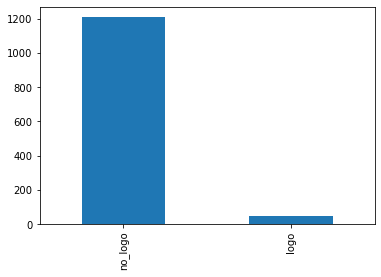

In [53]:
logo_not_logo_df.avg_top_1_class_name.value_counts().plot(kind="bar")

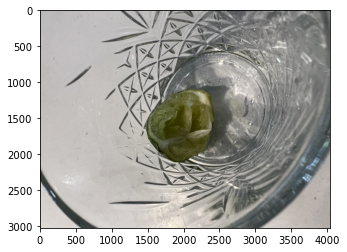

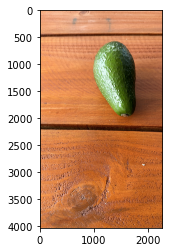

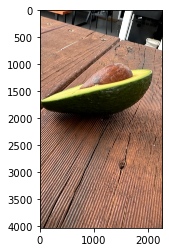

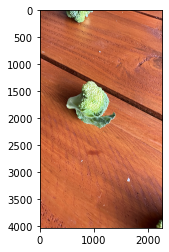

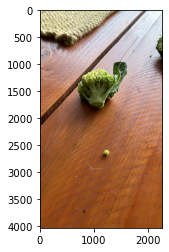

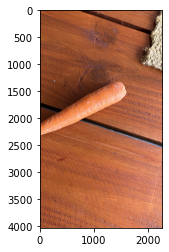

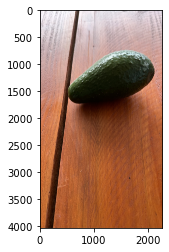

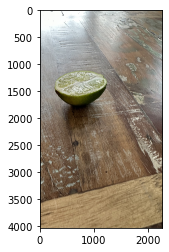

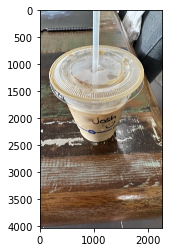

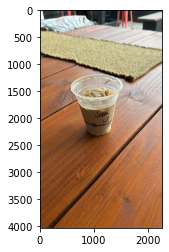

In [27]:
# Plot 10 random images where blip_top_1_class_name == "logo"
logo_samples = logo_not_logo_df[logo_not_logo_df["avg_top_1_class_name"] == "logo"].sample(10)

# Plot 10 images from the logo samples
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for row in logo_samples.iterrows():
    img = mpimg.imread(row[1]["image_path"])
    imgplot = plt.imshow(img)
    plt.show()

## Practice BLIP zero-shot on a single image

See the source: https://github.com/salesforce/LAVIS/blob/main/examples/blip_zero_shot_classification.ipynb

In [191]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [192]:
model, vis_processors, _ = load_model_and_preprocess("blip_feature_extractor", model_type="base", is_eval=True, device=device)

In [212]:
cls_names = ["edible_food", "other"]

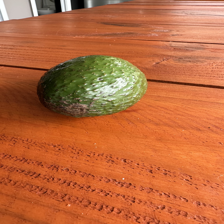

In [217]:
# Open a random image from all_paths
import random
image_path = random.choice(all_paths)
raw_image = Image.open(image_path).convert("RGB")
display(raw_image.resize((224, 224)))

In [218]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
image_features = model.extract_features({"image": image}, mode="image").image_embeds_proj[:, 0]

In [219]:
def blip_get_text_features_for_zero_shot_classification(text:list,
                                                        model=blip_feature_extractor_model):
    text_features = model.extract_features({"text_input": text}, mode="text").text_embeds_proj[:, 0]
    return text_features

text_features = blip_get_text_features_for_zero_shot_classification(["food", "not_food"])
text_features.shape

torch.Size([2, 256])

In [220]:
def blip_zero_shot_classification(image_features, text_features, class_names, blip_model=blip_feature_extractor_model):
    similarity_values = (image_features @ text_features.T)[0] / blip_model.temp
    probabilities = torch.softmax(similarity_values, dim=0).tolist()

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    return class_name_similarity_probability_dict

edible_food: 	 39.969%
other: 	 60.031%


## Practice CLIP zero-shot on a single image

In [171]:
clip_feature_extractor_model, clip_vis_processors, clip_txt_processors = load_model_and_preprocess("clip_feature_extractor", model_type="ViT-L-14", is_eval=True, device=device)

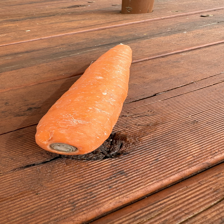

In [268]:
# Open a random image from all_paths
import random
image_path = random.choice(all_paths)
raw_image = Image.open(image_path).convert("RGB")
display(raw_image.resize((224, 224)))

In [269]:
# Process image
image = clip_vis_processors["eval"](raw_image).unsqueeze(0).to(device)
clip_image_features = clip_feature_extractor_model.extract_features({"image": image})
clip_image_features.shape

torch.Size([1, 768])

In [270]:
def clip_get_text_features_for_zero_shot_classification(text:list,
                                                        model=clip_feature_extractor_model):
    features = model.extract_features({"text_input": text})
    return features

class_names = ["edible_food", "other"]
clip_text_features = clip_get_text_features_for_zero_shot_classification(class_names)
clip_text_features.shape

torch.Size([2, 768])

In [271]:
def clip_zero_shot_classification(image_features, text_features, class_names, clip_model=clip_feature_extractor_model):
    similarity_values = (image_features @ text_features.T)[0] / 0.01
    probabilities = torch.softmax(similarity_values, dim=0).tolist()

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    return class_name_similarity_probability_dict

In [272]:
clip_zero_shot_classification(clip_image_features, clip_text_features, class_names)

{'edible_food': 1.0, 'other': 0.0}

## Try OpenCLIP for zero-shot classification

See: https://github.com/mlfoundations/open_clip 

And a notebook example: https://colab.research.google.com/github/mlfoundations/open_clip/blob/master/docs/Interacting_with_open_clip.ipynb 

In [167]:
import torch
from PIL import Image
import open_clip
from tqdm.auto import tqdm

open_clip_model_name = "ViT-H-14"
open_clip_model, _, open_clip_preprocess = open_clip.create_model_and_transforms(open_clip_model_name, pretrained='laion2b_s32b_b79k')
open_clip_tokenizer = open_clip.get_tokenizer(open_clip_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
open_clip_model.to(device);

def open_clip_compute_image_features_of_list(image_paths: list,
                                             open_clip_model=open_clip_model,
                                             open_clip_preprocess=open_clip_preprocess,
                                             device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing OpenCLIP image features"):
        image_feature_dict = {}

        image = open_clip_preprocess(Image.open(image_path)).unsqueeze(0)

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = open_clip_model.encode_image(image.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)       

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features
        image_features_list.append(image_feature_dict)
    
    return image_features_list

def open_clip_compute_text_features(text: list,
                                    open_clip_model=open_clip_model,
                                    open_clip_tokenizer=open_clip_tokenizer,
                                    devce=device):

    text = open_clip_tokenizer(text)

    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = open_clip_model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    return text_features

def open_clip_zero_shot_classification(image_features, text_features, class_names, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    with torch.no_grad(), torch.cuda.amp.autocast():
        similarity_values = (image_features @ text_features.T)[0] / 0.01
        probabilities = torch.softmax(similarity_values, dim=-1).cpu().tolist() # return values to CPU

        # Create a dict of class names and their probabilities
        class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict



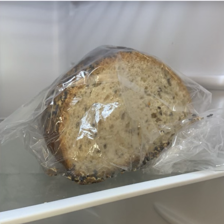

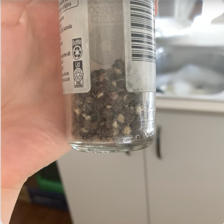

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

{'pepper': 0.9710848927497864,
 'salt': 0.028869593515992165,
 'other': 4.5486664021154866e-05}

In [178]:
# Randomly select an image from all_paths
import random
import glob
# all_paths = glob.glob("food_photos/*/*.jpeg")
# image_path = random.choice(all_paths)
image_path = "pepper-image.png"
display(Image.open(image_path).resize((224, 224)))

class_names = ["salt", "pepper", "other"]
open_clip_image_feature_list = open_clip_compute_image_features_of_list([image_path])
bread_text_features = open_clip_compute_text_features(class_names)
open_clip_zero_shot_classification(image_features=open_clip_image_feature_list[0]["image_features"],
                                   text_features=bread_text_features,
                                   class_names=class_names)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_429979/396625807.py:1 in <cell line: 1>                                           │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_429979/396625807.py'                        │
│                                                                                                  │
│ /tmp/ipykernel_429979/3383192226.py:49 in open_clip_zero_shot_classification                     │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_429979/3383192226.py'                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'list' object has no attribute 'to'